## this code is a modifiction on ANGLE's notebook here's a link to the original notebook
https://www.kaggle.com/code/lblhandsome/optiver-robust-best-single-model

I've added new features, normalization and small changes on the model
but I should mention the training time on inference has increased 

In [1]:
import gc
import os
import time
import warnings
from itertools import combinations
from warnings import simplefilter

import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_offline = False
is_train = True
is_infer = True
max_lookback = np.nan
split_day = 435

In [2]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

In [3]:
df = df.dropna(subset=["target"])
df.reset_index(drop=True, inplace=True)
df.shape

(5237892, 17)

## Memory reduce function

In [4]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    return df


## Speed up triplet imbalance calculations

In [5]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            if mid_val == min_val:  # Prevent division by zero
                imbalance_features[j, i] = (max_val - mid_val) /0.0001
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

## Feature groups

In [6]:
# generate imbalance features
def imbalance_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    #A positive value suggests more buying interest, while a negative value suggests more selling interest.
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    df['auction_mktcap'] = df.eval("matched_size * reference_price")
    df['weight1'] = df['auction_mktcap']/df.groupby(['date_id','seconds_in_bucket'])['auction_mktcap'].transform('sum') * df['wap']
    df['index1'] = df.groupby(['date_id','seconds_in_bucket'])['weight1'].transform('sum')
    
    df['weight2'] = df['matched_size']/df.groupby(['date_id','seconds_in_bucket'])['matched_size'].transform('sum') * df['wap']
    df['index2'] = df.groupby(['date_id','seconds_in_bucket'])['weight2'].transform('sum')
    
    df['index3'] = df.groupby(['date_id','seconds_in_bucket'])['wap'].transform('mean')
    ##########################################################################
#     df["ask_size_divided_by_sum_size"] = df["ask_size"] / (df["ask_size"] + df["bid_size"])
#     df["bid_size_divided_by_sum_size"] = df["bid_size"] / (df["ask_size"] + df["bid_size"])
#     df["asks_bids_dif"] = (df["ask_size"] - df["bid_size"])
#     df["bids_divided_by_bidp"] = df["bid_size"] / df["bid_price"]
#     df["asks_divided_by_askp"] = df["ask_size"] / df["ask_price"]
#     df["bids_divided_by_bidp_asks_divided_by_askp_diff"] = df["bids_divided_by_bidp"] - df["asks_divided_by_askp"]
#     df["difsize_div_by_sumprice"] = (df["bid_size"] - df["ask_size"]) / (df["bid_price"] + df["ask_price"])
#     df["bids_times_bidp"] = (df["bid_size"] * df["bid_price"])
#     df["asks_times_askp"] = (df["ask_size"] * df["ask_price"])
#     df["wap_ref_diff"] =df["wap"] - df["reference_price"]
#     df["wap_bidp_diff"] =df["wap"] - df["bid_price"]
#     df["ref_divby_wap"] =df["reference_price"] / df["wap"]
#     df["bidp_divby_wap"] =df["bid_price"] / df["wap"]
#     df["askp_divby_wap"] =df["ask_price"] / df["wap"]
#     df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
#     df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
#     df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df_agg = df.groupby(["stock_id",'date_id'])
    df['index_ret_1'] = df_agg['index1'].pct_change()
    df['wap_index_spread'] = df.eval("(wap - index1)*10000")
    for index in ['index1','index3']:
        for win in [1, 2, 3, 6]:
            df[f'wap_{index}_diff_{win}'] = (df['wap']/df_agg['wap'].shift(win) - df[index]/df_agg[index].shift(win))*10000 
    df['imb_size_sign'] = df.eval("imbalance_size * imbalance_buy_sell_flag")
    df["imb_sign_imb"] = df.eval("imb_size_sign/matched_size")
    df["imb_sign_imb_return_1"] = df_agg['imb_sign_imb'].pct_change()
    df["imbalance_momentum"] = df_agg['imb_size_sign'].diff(periods=1) / df['matched_size'] 
    df['price_spread_times_imb_size_sign'] = df['price_spread'] * df['imb_size_sign'] 
    ##########################################################################
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
        
    # V2
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
    # will calculate the percentage change between each day's price and the price from 6 days ago.
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * df["price_spread"]
    # how much does the imbalance have an effect on the diffrence between ask and bid price 
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        
    # V3
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = df_agg[col].shift(window)
            df[f"{col}_ret_{window}"] = df_agg[col].pct_change(window)
            
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size',
                'wap', 'near_price', 'far_price']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = df_agg[col].diff(window)
            
    for col in ['index1','index2','index3']:
        for window in [1, 2, 3]:
            df[f"{col}_diff_{window}"] = df_agg[col].diff(window)
            
    for col in ['index1','index2','index3']:
        for window in [1, 2, 3]:
            df[f"{col}_shift_{window}"] = df_agg[col].shift(window)
            df[f"{col}_ret_{window}"] = df_agg[col].pct_change(window)
            
    return df

# generate time & stock features

def other_features(df):
    df["dow"] = df["date_id"] % 5
    df["dom"] = df["date_id"] % 20
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60
#################################################################################
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df
#################################################################################
# generate all features
def generate_all_features(df):
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()
    
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]

In [7]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

weights = {int(k):v for k,v in enumerate(weights)}

In [8]:
def count_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Percentage': missing_values.values / len(df) * 100})
    missing_df = missing_df.sort_values(by='Missing Values', ascending=False)
    return missing_df

# Assuming 'your_dataframe' is your DataFrame
your_missing_values = count_missing_values(df)
pd.set_option('display.max_rows', 200)
# print(your_missing_values)

In [9]:
df.dropna(subset = ['target'], inplace=True)

## creating new features 

In [11]:
if is_offline:
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    df_train = df
    print("Online mode")

Online mode


In [12]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        df_train_feats.replace([np.inf, -np.inf], 0, inplace = True)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        df_valid_feats.replace([np.inf, -np.inf], 0, inplace = True)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        df_train_feats.replace([np.inf, -np.inf], 0, inplace = True)
        print("Build Online Train Feats Finished.")
    df_train_feats = reduce_mem_usage(df_train_feats)

Build Online Train Feats Finished.


## missing values after feature creation

In [15]:
df_train_feats.shape

(5237892, 194)

In [16]:
df = pd.concat([df_train_feats, df_train["target"], df_train["time_id"],df_train["date_id"] ], axis=1, ignore_index=False)

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler
scaler = MinMaxScaler()
elements_to_remove = ['seconds_in_bucket','time_id', 'date_id',"seconds", 'minute',
                      'imbalance_buy_sell_flag','target']
cols = df.columns.tolist()
cols = [item for item in cols if item not in elements_to_remove]
# Apply Min-Max scaling to each column
df_normalized_minmax = df.copy()
df_normalized_minmax[cols] = scaler.fit_transform(df[cols])

In [18]:
df_normalized_minmax.shape

(5237892, 197)

In [20]:
df_train_feats = df_normalized_minmax.drop(columns=["target", "time_id","date_id"])

> Because this is a time series dataset, we cannot use random KFold to partition the data, which will lead to data leakage (the model will have difficulty converging). Therefore, we strictly ensure that a part of the test set is not used, and divide all *training* data into (train, valid, test) in time series, valid is used as the basis for train iteration, and the optimal parameters are used on train.

In [22]:
if is_train:
    feature_name = list(df_train_feats.columns)
    lgb_params = {
        "objective" : "mae",#min absolute erorr
        "n_estimators" : 3000,
        "num_leaves" : 128,
        "max_depth" : 10,
        "subsample" : 0.6,
        "colsample_bytree" : 0.6,
        "learning_rate" : 0.05,
        "n_jobs" : 4,
        "device" : "gpu",
        "verbosity": -1,
        "importance_type" : "gain",
    }

    print(f"Feature length = {len(feature_name)}")

    offline_split = df_train['date_id']>(split_day - 45)
    
    df_offline_train = df_train_feats[~offline_split]
    df_offline_valid = df_train_feats[offline_split]
    df_offline_train_target = df_train['target'][~offline_split]
    df_offline_valid_target = df_train['target'][offline_split]

    print("Valid Model Trainning.")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_offline_train[feature_name],
        df_offline_train_target,
        eval_set=[(df_offline_valid[feature_name], df_offline_valid_target)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],
    )

    del df_offline_train, df_offline_valid, df_offline_train_target, df_offline_valid_target
    gc.collect()

    # infer
    df_train_target = df_train["target"]
    print("Infer Model Trainning.")
    infer_params = lgb_params.copy()
    infer_params["n_estimators"] = int(1.2 * lgb_model.best_iteration_)
    infer_lgb_model = lgb.LGBMRegressor(**infer_params)
    infer_lgb_model.fit(df_train_feats[feature_name], df_train_target)

    if is_offline:   
        # offline predictions
        df_valid_target = df_valid["target"]
        offline_predictions = infer_lgb_model.predict(df_valid_feats[feature_name])
        offline_score = mean_absolute_error(offline_predictions, df_valid_target)
        print(f"Offline Score {np.round(offline_score, 4)}")

Feature length = 194
Valid Model Trainning.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 5.89612
[200]	valid_0's l1: 5.88725
[300]	valid_0's l1: 5.88458
[400]	valid_0's l1: 5.88424
[500]	valid_0's l1: 5.88383
[600]	valid_0's l1: 5.88351
Early stopping, best iteration is:
[596]	valid_0's l1: 5.88347


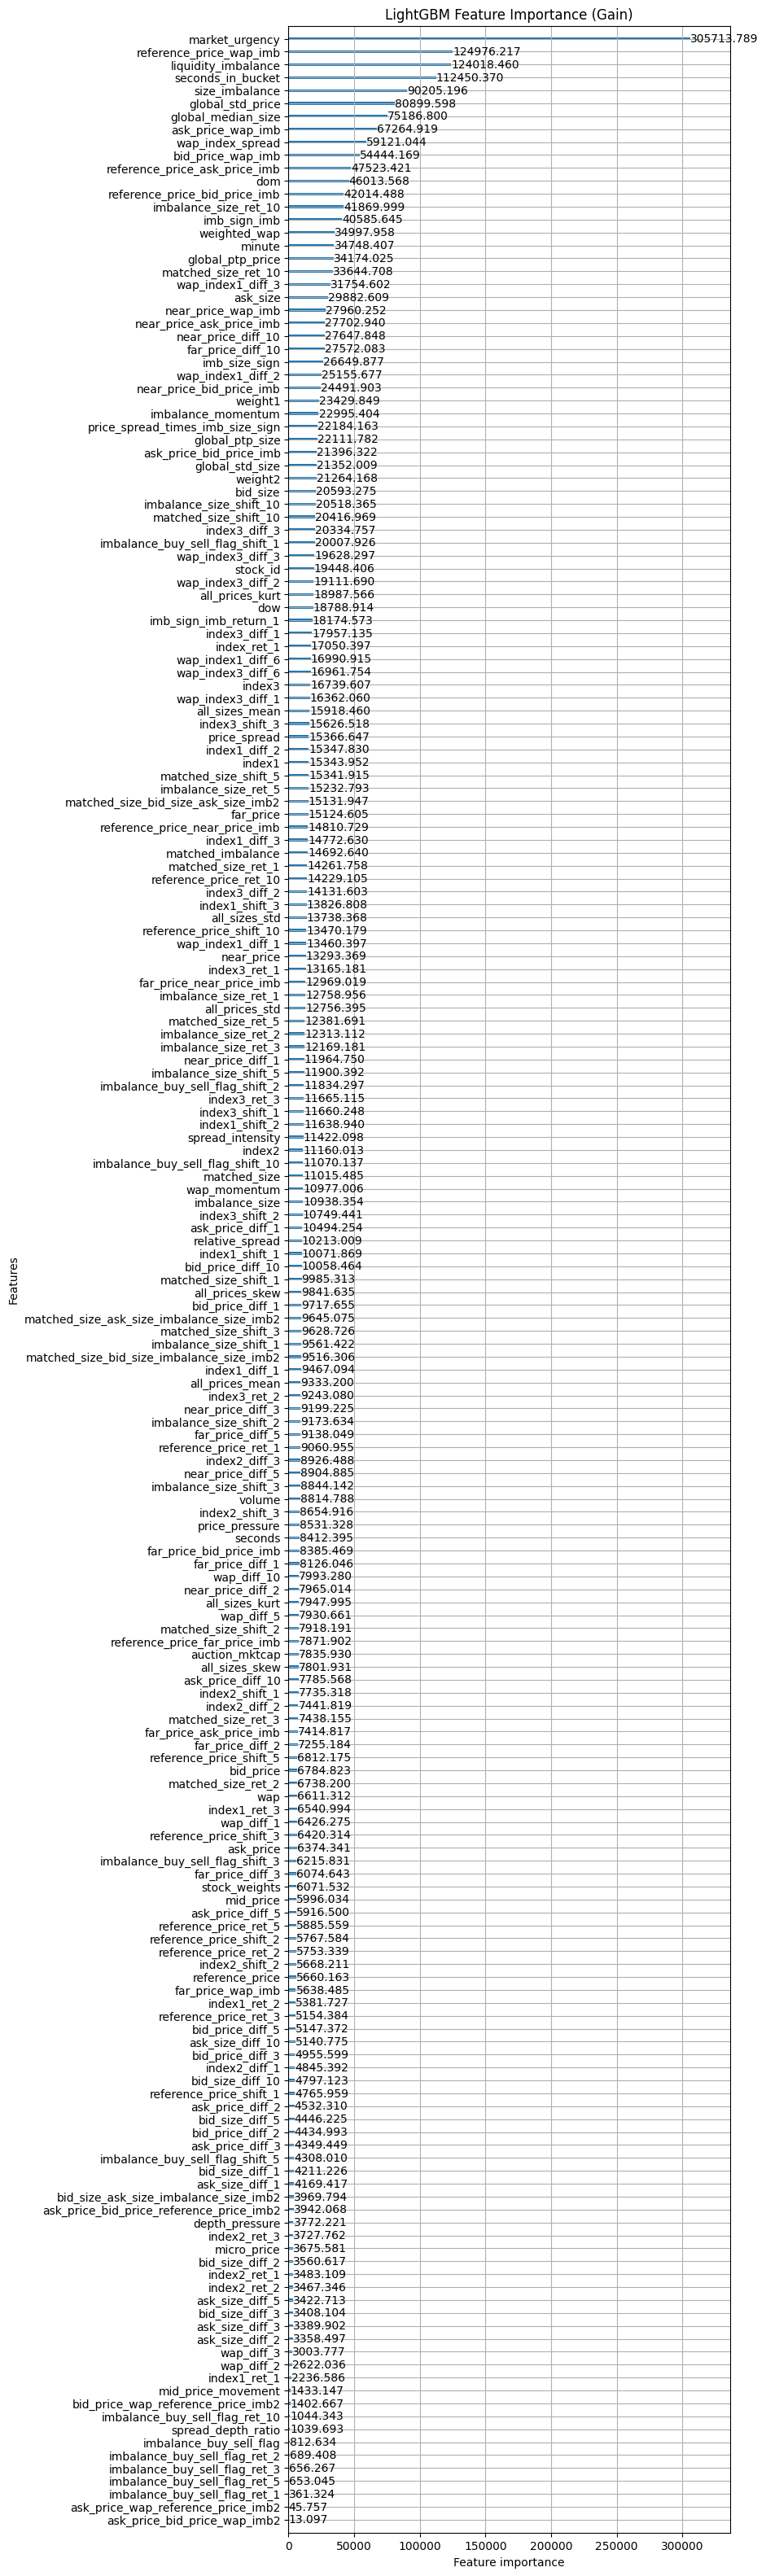

In [23]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(7,40), title="LightGBM Feature Importance (Gain)")
plt.show()

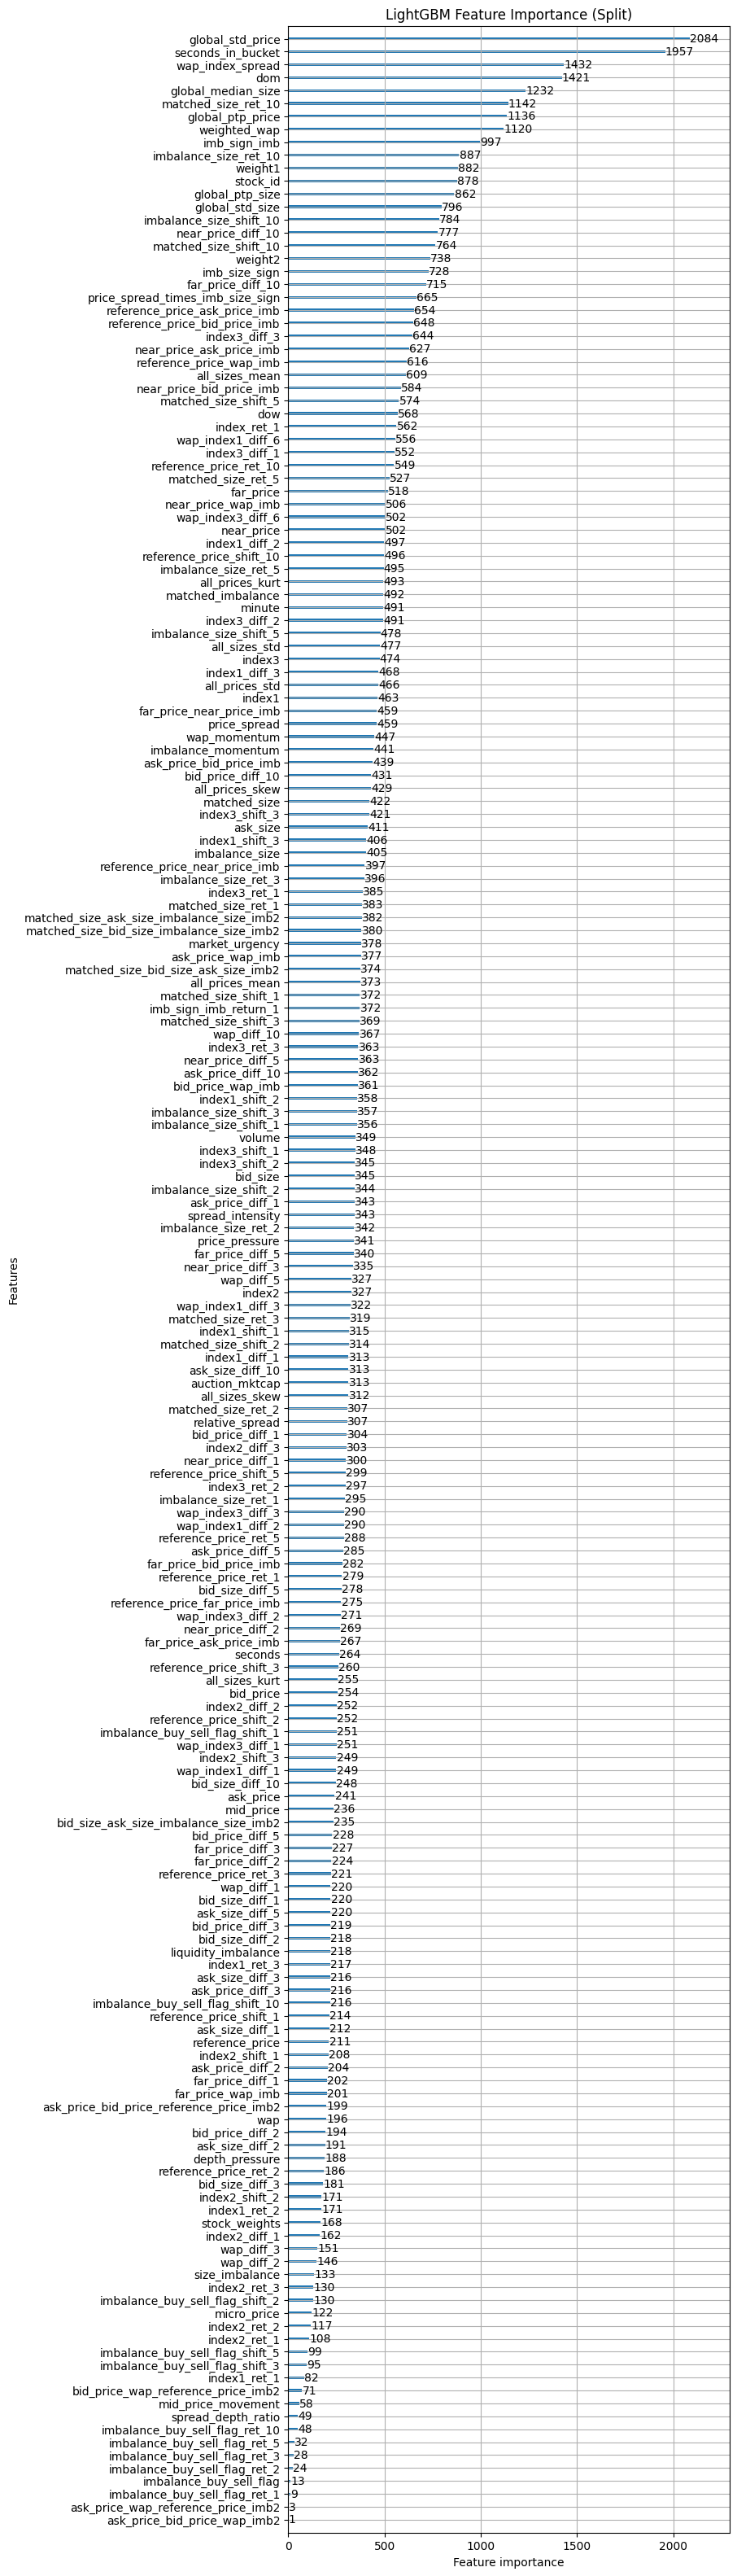

In [24]:
lgb.plot_importance(lgb_model, importance_type="split", figsize=(7,40), title="LightGBM Feature Importance (Split)")
plt.show()

| Version  | Feature Description                           | MAE(t/v) offline   | MAE(t/t) online       |  Inferance QPS  | Model              | Lookback |
| :-----:  | :-------------------------------------------: | :----------------: | :-------------------: | :-------------: | :----------------: | :------: |
| V1       | *Baseline* (41 feats)                         | 5.9712(*5.8578*)   | 5.9161(**5.3693**)    |  0.1887s        | LightGBM           |  /       |
| V2       | Add *imbalance* feature (58 feats)            | 5.9589(*5.8465*)   | 5.9055(**5.3700**)    |  0.2351s        | LightGBM           |  /       |
| V3       | Add *global* feature (68 feats)               | 5.9616(*5.8449*)   | 5.9069(**5.3683**)    |  0.1964s        | LightGBM           |  /       |
> **MAE(t/v)** means train/valid offline scoring, **MAE(t/t)** means train/test online scoring. Inferance QPS means the inference time of a single piece of data (including feature engineering, model prediction). Lookback means the maximum number of lookback seqs for data and models.

In [ ]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices)/np.sum(std_error)
    out = prices-std_error*step
    
    return out

if is_infer:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = generate_all_features(cache)[-len(test):]
        feat = feat.drop(['currently_scored'], axis=1)
        lgb_prediction = infer_lgb_model.predict(feat)
#         lgb_prediction = zero_sum(lgb_prediction, test['bid_size'] + test['ask_size'])
        lgb_prediction = lgb_prediction - np.mean(lgb_prediction)
        clipped_predictions = np.clip(lgb_prediction, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))
           
    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")